In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv('data/serieA_matches.csv')
df_all_matches = pd.read_csv('data/2020_all_matches.csv')

In [4]:
df.shape

(12710, 119)

In [5]:
%%time

home_teams = df_all_matches[['Home', 'Venue']].drop_duplicates().values
team_stadium = {}
for data in home_teams:
     team_stadium[data[0]] = data[1]

CPU times: user 896 µs, sys: 4.21 ms, total: 5.1 ms
Wall time: 4.74 ms


In [6]:
%%time


team_dict = {}
for idx, team in enumerate(df['team'].unique()):
    team_dict[team] = idx

CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 2.14 ms


In [7]:
%%time

df['is_home'] = team_stadium[df['team'].iloc[0]]
df['is_home'] = df['stadium'] == df['is_home']
df['is_home'] = df['is_home'].astype(int)

CPU times: user 6.93 ms, sys: 0 ns, total: 6.93 ms
Wall time: 14.9 ms


In [8]:
cols_types = df.dtypes
cols_types[cols_types == object]

team       object
result     object
stadium    object
state      object
UF         object
date       object
time       object
dtype: object

In [9]:
df.head(2)

,fouls,corners,crosses,touches,tackles,interceptions,aerials_won,clearances,offsides,goal_kicks,...,fouls_drawn_mean_attack,offsides_mean_attack,crosses_mean_attack,tackles_on_mean_attack,interceptions_mean_attack,own_goals_mean_attack,penalty_kicks_won_mean_attack,penalty_kicks_conceded_mean_attack,year,is_home
0,23.0,3.0,11.0,436.0,12.0,5.0,7.0,18.0,2.0,4.0,...,0.0,2.0,1.0,0.0,1.0,0.0,NaN,NaN,2019,0
1,23.0,3.0,11.0,436.0,12.0,5.0,7.0,18.0,2.0,4.0,...,0.0,2.0,1.0,0.0,1.0,0.0,NaN,NaN,2019,0


In [10]:
%%time

# df['date'] = pd.to_datetime(df['date'])
df['time'] = df['time'].apply(lambda time: time.split(':')[0]).astype(int)

CPU times: user 9.79 ms, sys: 3.52 ms, total: 13.3 ms
Wall time: 15 ms


In [11]:
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df['quarter'] = df['date'].dt.quarter
# df['day'] = df['date'].dt.day

In [12]:
cols_to_remove = [
    'score',
    "date",
#     'team',
    "stadium",
    "state",
    "UF",
#     "match_id"
]
y_col = 'score'

In [13]:
%%time
df.drop(columns=cols_to_remove, inplace=True)

CPU times: user 8.04 ms, sys: 4.01 ms, total: 12 ms
Wall time: 11.7 ms


In [14]:
%%time
team_dict = {}
for idx, team in enumerate(df['team'].unique()):
    team_dict[team] = idx

CPU times: user 2.09 ms, sys: 449 µs, total: 2.54 ms
Wall time: 1.88 ms


In [15]:
%%time
feature_cols = [col for col in df.columns if col not in cols_to_remove]

CPU times: user 43 µs, sys: 10 µs, total: 53 µs
Wall time: 56.3 µs


In [16]:
%%time

df_home_teams = pd.DataFrame()
df_adversary_teams = pd.DataFrame()

df_teams = pd.DataFrame()
for team in df['team'].unique():
    cols_to_drop = ['is_home', 'team', 'result']
    unique_cols = ['match_id', 'matchweek', 'time', 'year']

    df_team = df[df['team'] == team].copy().reset_index(drop=True)
    df_others_teams = df[
        (df['team'] != team) &
        (df['match_id'].isin(df_team['match_id'].tolist()))
    ].copy().reset_index(drop=True)
    
    columns = [col for col in df_team.columns if col not in cols_to_drop]
    df_team.loc[df_team.index >= 3, columns] = (
        df_team[columns]
        .shift(1)
        .rolling(3)
        .mean()
        .iloc[3:]
    ).copy()

    df_others_teams.loc[df_others_teams.index >= 3, columns] = (
        df_team[columns]
        .shift(1)
        .rolling(3)
        .mean()
        .iloc[3:]
    ).copy()

    df_others_teams.drop(columns=cols_to_drop, inplace=True)
    df_others_teams.columns = [
        col + '_adversary' if col not in unique_cols else col for col in df_others_teams.columns
    ]
    
    
#     df_home_teams = df_home_teams.append(df_team)
#     df_adversary_teams = df_adversary_teams.append(df_others_teams)

    for col in [column for column in df_others_teams.columns if column.endswith('adversary')]:
        df_team[col] = df_others_teams[col]
#     df_teams = df_teams.append(
#         df_team.merge(df_others_teams, on='match_id')
#     )

CPU times: user 6.98 s, sys: 2.22 ms, total: 6.98 s
Wall time: 6.99 s


In [17]:
df_teams = df_team

In [18]:
%%time

# df_home_teams = df_home_teams.append(df_team)
# df_adversary_teams = df_adversary_teams.append(df_others_teams)

# df_teams = df_home_teams.merge(df_adversary_teams, on=unique_cols)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


In [19]:
# 1/0

In [20]:
df_teams = df_teams[~df_teams['team'].isna()].copy()

In [21]:
df_teams['team'] = df_teams['team'].apply(lambda team: team_dict[team])

In [22]:
%%time

result_map = {
    'L': 0,
    'D': 1,
    'W': 3
}

df_teams = df_teams[~df_teams['result'].isna()]
df_teams['result'] = df_teams['result'].apply(lambda result: result_map[result])

CPU times: user 3.64 ms, sys: 0 ns, total: 3.64 ms
Wall time: 3.38 ms


In [23]:
df_teams['result'].fillna(-1, inplace=True)
df_teams = df_teams[df_teams['result'] != -1]
df_teams['result'] = df_teams['result'].astype(int)

In [24]:
# df_teams['date'] = pd.to_datetime(df_teams['date'])



In [25]:
# df_teams.drop(columns=['date', 'date_adversary'], inplace=True)

In [26]:
X = df_teams.drop(columns=['result'])
Y = df_teams['result']

In [27]:
# score
# result

# df.drop(columns=['result'], inplace=True)

In [28]:
# df.drop(columns=cols_to_remove, inplace=True)

In [29]:
# df

In [30]:
# model = XGBClassifier()

# rfe = RFE(model, 25)
# fit = rfe.fit(X, Y)
# print("Num Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)
# print("Feature Ranking: %s" % fit.ranking_)

In [31]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# test = SelectKBest(score_func=f_classif, k=25)
# fit = test.fit(X, Y)
# # summarize scores
# print(fit.scores_)
# features = fit.transform(X)

In [32]:
# cols = np.array(np.array(X.columns.tolist()))[list(fit.support_)]

In [33]:
# X = X[cols]

In [34]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    difference = list(np.abs((y_true - y_pred) / y_true))
    difference = [diff if diff != np.inf and not pd.isnull(diff) else 0 for diff in difference]
    return np.mean(difference)


In [36]:
X.sort_values(['matchweek', 'team', 'year'], inplace=True)

In [37]:
# %%time
# # # n_cols_list = [5, 15, 25, 35, 45, 50, 63, 72, 84, 90, 100]
# # # for n_cols in n_cols_list:
n_cols = 80

# model = XGBClassifier()

# rfe = RFE(model, n_cols)
# fit = rfe.fit(X.iloc[:1000], Y.iloc[:1000])

# cols = np.array(np.array(X.columns.tolist()))[list(fit.support_)]
# X_new = X[cols]


In [38]:
X_new = X
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.1, random_state=7)

In [39]:
# %%time
# parameters = {
#     'eta': [0.05, 0.1, 0.3],
#     'max_depth': [5, 6, 9, 12, 20],
#     'subsample': [0.7, 0.6, 0.8, 1.0],
#     'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
#     'min_child_weight': [1, 5, 8, 10],
#     'gamma': [0.5, 1, 1.5, 2, 5],
#     'n_estimators': [50, 100, 150, 500, 1000]
# }

# clf = GridSearchCV(model, parameters, n_jobs=1, cv=3)

# clf.fit(X_train, y_train)

# best_parameters = clf.best_params_

# model = XGBRegressor(**best_parameters)
model = XGBClassifier()

In [40]:
%%time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


model.fit(X_train, y_train)

y_pred = list(model.predict(X_test))
predictions = list([round(value) for value in y_pred])

# evaluate predictions
accuracy = mean_absolute_percentage_error(y_test, predictions)
f1 = f1_score(y_test, predictions, average='macro')
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')

print("Accuracy with {} columns: {:.2f}%".format(n_cols, 100 - accuracy * 100.0))
print("Precision with {} columns: {:.2f}".format(n_cols, precision))
print("Recall with {} columns: {:.2f}".format(n_cols, recall))
print("F1 with {} columns: {:.2f}".format(n_cols, f1))


Accuracy with 80 columns: 95.65%
Precision with 80 columns: 0.90
Recall with 80 columns: 0.91
F1 with 80 columns: 0.90
CPU times: user 2.44 s, sys: 20.5 ms, total: 2.47 s
Wall time: 832 ms


<ipython-input-35-70d46a524b4a>:5: RuntimeWarning: divide by zero encountered in true_divide
  difference = list(np.abs((y_true - y_pred) / y_true))
<ipython-input-35-70d46a524b4a>:5: RuntimeWarning: invalid value encountered in true_divide
  difference = list(np.abs((y_true - y_pred) / y_true))


In [41]:
y_test.value_counts()

1    11
3     6
0     6
Name: result, dtype: int64

In [42]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(train[predictors],train[target])
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# ==================================================

In [43]:
match_per_round = df['matchweek'].value_counts().to_frame()
last_matchweek = match_per_round[match_per_round > 5].sort_values('matchweek', ascending=False).iloc[0].name

In [44]:
last_match_id = df[df['year'] == 2020]['match_id'].max()

In [45]:
next_matches = pd.read_csv('data/2020_all_matches.csv')

In [46]:
next_matches['Score'] = next_matches['Score'].fillna('')

In [47]:
next_matches = next_matches[next_matches['Score'] == '']
next_matches['Wk'] = next_matches['Wk'].fillna('')
next_matches = next_matches[next_matches['Wk'] != '']

In [48]:
next_matches = next_matches[next_matches['Wk'] > last_matchweek]

In [49]:
def make_dataset(interested_team, other_team, cols):
    cols_to_use = [col for col in interested_team.columns if 'adversary' not in col]
    
    interested_team = interested_team[cols_to_use]
    other_team = other_team[cols_to_use]
    
    other_team.columns = [col + '_adversary' if col not in ['result', 'match_id'] else col for col in interested_team.columns ]
    
    df = interested_team.merge(other_team, on='match_id')

    return df[cols]
    

In [50]:
next_matchweek = df_teams['matchweek'].max() + 1

In [51]:
predictions = pd.DataFrame()

In [52]:
problem_teams = []
for next_match in next_matches.iterrows():
    try:
        next_match = next_match[1].to_frame().transpose()
        team1, team2 = next_match[['Home', 'Away']].iloc[0]
        date = pd.to_datetime(next_match['Date'].iloc[0])
        time = next_match['Time'].iloc[0].split(':')[0]
        matchweek = int(next_match['Wk'].iloc[0])

        if team1 not in team_dict.keys():
            team_dict[team1] = max(team_dict.values()) + 1

        if team2 not in team_dict.keys():
            team_dict[team2] = max(team_dict.values()) + 1
        
        if matchweek == next_matchweek:

            cols = X_new.columns.tolist()
            mean_features_team1 = df[(df['team'] == team1) & (df['year'] == 2020)].copy()  # [cols]
            mean_features_team2 = df[(df['team'] == team2) & (df['year'] == 2020)].copy()  # [cols]
            
            if mean_features_team1.shape[0] == 0:
                print(team1)
            
            if mean_features_team2.shape[0] == 0:
                print(team2)
            mean_features_team1['match_id'] = last_match_id + 1
            mean_features_team2['match_id'] = last_match_id + 1

        #     for col in cols:
        #         mean_features_team1[col] = mean_features_team1[col].shift(1).rolling(window=3).mean().copy()
        #         mean_features_team2[col] = mean_features_team2[col].shift(1).rolling(window=3).mean().copy()

            for col in df.columns:
                if df[col].dtype != object and col not in ['score', 'match_id']:
                    mean_features_team1[col] = mean_features_team1[col].shift(1).rolling(window=3).mean().copy()
                    mean_features_team2[col] = mean_features_team2[col].shift(1).rolling(window=3).mean().copy()

            mean_features_team1 = mean_features_team1.iloc[-1:].copy()
            mean_features_team2 = mean_features_team2.iloc[-1:].copy()

            mean_features_team1['is_home'] = 1
            mean_features_team2['is_home'] = 0

            mean_features_team1['team'] = team_dict[team1]
            mean_features_team2['team'] = team_dict[team2]

            dataset_team1 = make_dataset(mean_features_team1, mean_features_team2, cols).round(2)
            dataset_team2 = make_dataset(mean_features_team2, mean_features_team1, cols).round(2)

            game_prediction = dataset_team1.append(dataset_team2)
            prediction = [round(prediction) for prediction in list(model.predict(game_prediction))]
        #     print(f"Rodada {matchweek}: {team1} {prediction[0]} x {prediction[1]} {team2}!")
            print(f"Rodada {matchweek}:\n {team1}: {prediction[0]} \n  {team2}: {prediction[1]}\n\n")
            last_match_id += 1
            
            
            predictions = predictions.append(pd.DataFrame({
                'matchweek': [matchweek],
                'team1': [team1],
                'prediction_team1': [prediction[0]],
                'team2': [team2],
                'prediction_team2': [prediction[1]],
            }))
    except Exception as e:
#         print(e)
#         print(mean_features_team1.shape)
#         print(mean_features_team2.shape)
        pass

Rodada 15:
 Vasco da Gama: 1 
  Flamengo: 0


Rodada 15:
 Coritiba: 3 
  Fortaleza: 1


Rodada 15:
 Palmeiras: 3 
  São Paulo: 1


Rodada 15:
 Atlético Mineiro: 3 
  Goiás: 1


Rodada 15:
 Fluminense: 3 
  Bahia: 0


Rodada 15:
 Santos: 3 
  Grêmio: 0


Rodada 15:
 Sport Recife: 0 
  Botafogo (RJ): 0


Rodada 15:
 Atl Goianiense: 0 
  Bragantino: 0


Rodada 15:
 Ceará: 0 
  Corinthians: 0


Rodada 15:
 Internacional: 1 
  Atl Paranaense: 3




In [54]:
predictions.to_csv('data/predictions.csv', index=False)

In [ ]:
# team_dict

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

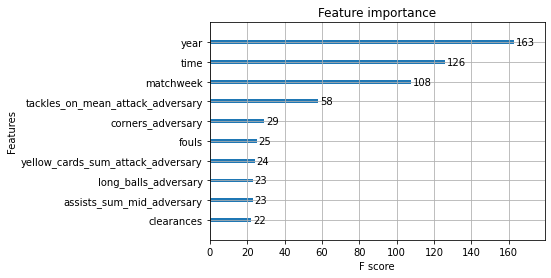

In [55]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10)

In [61]:
filename = 'data/serial/xgboost_regressor.model'

In [62]:
import pickle

with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [63]:
with open(filename, 'rb') as file:
    m = pickle.load(file)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

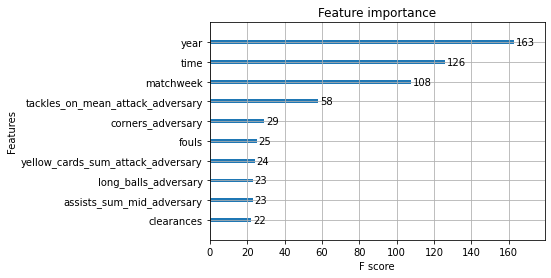

In [64]:
plot_importance(m, max_num_features=10)